### eval testing

## import lib & var setting

In [1]:
# Import Pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visulization
import matplotlib.pyplot as plt

import sys 

import cv2

import pandas as pd  # 資料分析套件
import numpy as np
import os
from time import time
import re
from timeit import default_timer as timer

import asyncio 

In [2]:
# ===== var setting   ========

# csv_file = '../data/img_feature.csv'
# csv_file = '../data/img_feature_no_masked.csv'
csv_file = '../data/img_conv2.csv'
# random_seed = 42
# dataset_path = "../HAM10000/base_img_data/"
dataset_path = "../HAM10000/images/"
groundtruth_file = '../HAM10000/GroundTruth.csv'

## prepocessing train & test data

### create name to label dict

### 分出train 跟test的data loader

In [3]:
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from helperFunction.CustomImageDataset import CustomImageDataset 


gray_mean = sum([0.485, 0.456, 0.406]) / 3
gray_std = sum([0.229, 0.224, 0.225]) / 3


# 可以加入轉換
transform64 = torchvision.transforms.Compose([
    transforms.Resize(size=(64,64)),
    torchvision.transforms.ToTensor()
    # 其他轉換
])

transform_std = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_gray_single_channel = transforms.Compose([
    transforms.Resize(256),  # 调整图像大小至256x256
    transforms.CenterCrop(224),  # 中心裁剪至224x224
    transforms.Grayscale(),  # 将图像转换为灰度图
    transforms.ToTensor(),  # 转换为Tensor
    # 归一化，均值和标准差应根据灰度图的实际分布进行调整
    # 这里使用ImageNet预训练模型的均值和标准差的平均值作为示例
    transforms.Normalize(mean=[0.449], std=[0.226]),
])

transform_gray_pretrain_fit = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # 将图像转换为单通道灰度图像
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 复制灰度通道到三个通道
    # 其他需要的转换，如 Resize, Normalize 等
    transforms.Resize(256),  # 例如，调整图像大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 归一化
])

transform_gray_CT_img_fit = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # 将图像转换为单通道灰度图像
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 复制灰度通道到三个通道
    # 其他需要的转换，如 Resize, Normalize 等
    transforms.Resize(256),  # 例如，调整图像大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为Tensor
    transforms.Normalize(mean=[gray_mean,gray_mean,gray_mean], std=[gray_std,gray_std,gray_std]),  # 归一化
])




In [4]:
# @transform test unit

# image = Image.open('../data/chestCTData/images/train/adenocarcinoma/000000 (6).png')

# # 打印图像的格式
# print("Format:", image.format)

# # 打印图像的尺寸
# print("Size:", image.size)

# # 打印图像的模式
# print("Mode:", image.mode)

# # 打印图像的额外信息（如果有的话）
# print("Info:", image.info)

# # 将图像转换为NumPy数组
# image_array = np.array(image)

# # 打印图像数组的形状和部分像素值
# print("Image shape:", image_array.shape)
# print("Some pixel values:", image_array[100:110, 100:110])  # 打印左上角5x5区域的像素值

# transformed_img = transform_gray(image)

# print(transformed_img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


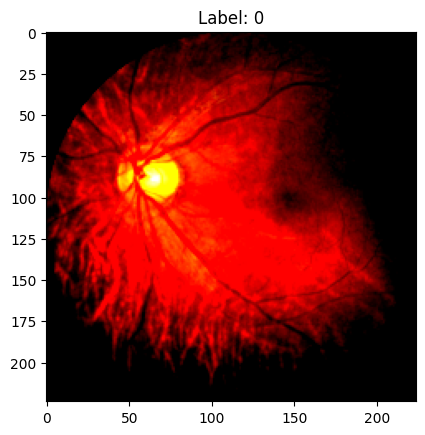

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


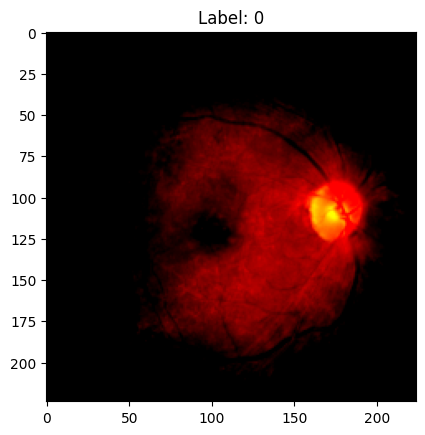

In [6]:
sys.path.append(os.path.abspath('..'))

from data.chestCTData.chestCTDataloader import ChestCTDataProcessor
from data.HAM10000.ham10000Dataloader import HAM10000DataProcessor
from data.ocularDisease.ocularDataloader import OcularDiseaseDataProcessor

# dataContainer = ChestCTDataProcessor(transform=transform_gray_single_channel) # for [1,224,224]
# dataContainer = ChestCTDataProcessor(transform=transform_std) # for [3,224,224]
# dataContainer = HAM10000DataProcessor(transform=transform_std)
dataContainer = OcularDiseaseDataProcessor(transform=transform_std)


# model_folder_path = '../model/CT chest'
# model_folder_path = '../model/HAM10000'
model_folder_path = '../model/ocularDisease'

# transform_file_prefix = "/one_channel"
transform_file_prefix = "/three_channel"

train_dataloader , test_dataloader = dataContainer.getDataloaders()

num_classes = dataContainer.getNumClasses()

# dataContainer.dataPreprocess()

dataContainer.plotNumsSampleImg()

In [7]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can cahnge the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}") # equal to batch siz

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [19]:
# 儲存file list的資訊給XGB訓練時使用
# import json
# with open('test_files_list.json', 'w') as f:
#     json.dump(test_files, f)
# with open('train_files_list.json', 'w') as f:
#     json.dump(train_files, f)

In [8]:
import torch
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Train & test function defination

In [9]:
# Cteate train_step()
def train_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop thourgh data loader data batches
  for batch,(X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device) , y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5 Optimizer step
    optimizer.step()

    # Calculat accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [10]:
from sklearn.metrics import f1_score
# Create a test step
def test_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device=device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc, all_preds, all_labels = 0, 0, [], []

  with torch.inference_mode():
    # Loop thourgh data loader data batches
    for batch,(X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device) , y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()


      # Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1) # Maybe same as softmax results?
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

      all_preds.extend(test_pred_labels.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  # cal F1 score
  f1 = f1_score(all_labels, all_preds, average='weighted')

  return test_loss, test_acc, f1

In [11]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss functoin
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          best_model_name: str = "best_model.pth",
          device=device,
          enable_early_stop=True):
  # 2. Create empty results dicitonary
  results = {"train_loss": [],
        "train_acc":[],
        "test_loss": [],
        "test_acc":[]}
  
  # init best model loss var
  best_test_loss = float('inf')
  best_model = None
  early_stop_count = 0
  early_stop_limit = 7

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                        dataloader=train_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device)
    test_loss, test_acc, test_f1 = test_step(model=model,
                      dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      device=device)
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} |  F1 score: {test_f1:.4f}   ")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    if test_loss < best_test_loss:
      best_test_loss = test_loss
      best_test_acc = test_acc
      best_test_f1 = test_f1
      # best_model = model.state_dict()
      torch.save(model.state_dict(), best_model_name)
      early_stop_count = 0
    else:
      if enable_early_stop:
        early_stop_count += 1
    
    if early_stop_count >= early_stop_limit:
      print("Early stopping triggered.")
      break

  # 6. Return the filled results at the end of the eopchs
      
  # save best model
  # torch.save(best_model, best_model_name)
  print("the best test acc is :{:.4f}".format(best_test_acc))
  print("the best F1 score is :{:.4f}".format(best_test_f1))
  return results

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train model

## VGG

load preTrained VGG16, num_class = 1000

In [29]:
import torchvision.models as models

model_preTrained_VGG16 = models.vgg16(pretrained=True).to(device)     # 使用內建的 model 

optimizer = torch.optim.SGD(model_preTrained_VGG16.parameters(), lr = 0.001) # 選擇你想用的 optimizer
# optimizer = torch.optim.Adam(model_VGG16.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 

# Start the timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_VGG16,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name= model_folder_path + "/best_model_pretrain_VGG16_1000.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 3.1632 | Train acc: 0.3028 | Test loss: 1.3673 | Test acc: 0.4921 |  F1 score: 0.4772   


  2%|▎         | 1/40 [00:16<10:43, 16.51s/it]

Epoch: 1 | Train loss: 1.2012 | Train acc: 0.5963 | Test loss: 1.0539 | Test acc: 0.5698 |  F1 score: 0.5563   


  5%|▌         | 2/40 [00:28<08:53, 14.03s/it]

Epoch: 2 | Train loss: 0.8656 | Train acc: 0.6750 | Test loss: 0.9513 | Test acc: 0.5681 |  F1 score: 0.5541   


 10%|█         | 4/40 [00:51<07:20, 12.23s/it]

Epoch: 3 | Train loss: 0.7793 | Train acc: 0.6981 | Test loss: 3.1282 | Test acc: 0.2466 |  F1 score: 0.1630   


 12%|█▎        | 5/40 [01:02<06:50, 11.72s/it]

Epoch: 4 | Train loss: 0.7704 | Train acc: 0.7369 | Test loss: 1.0096 | Test acc: 0.5786 |  F1 score: 0.5484   
Epoch: 5 | Train loss: 0.5149 | Train acc: 0.8063 | Test loss: 0.8682 | Test acc: 0.6220 |  F1 score: 0.6045   


 18%|█▊        | 7/40 [01:25<06:23, 11.62s/it]

Epoch: 6 | Train loss: 0.4543 | Train acc: 0.8238 | Test loss: 1.5038 | Test acc: 0.5638 |  F1 score: 0.4828   
Epoch: 7 | Train loss: 0.4121 | Train acc: 0.8672 | Test loss: 0.8676 | Test acc: 0.6448 |  F1 score: 0.6195   


 20%|██        | 8/40 [01:38<06:20, 11.90s/it]

Epoch: 8 | Train loss: 0.3451 | Train acc: 0.8812 | Test loss: 0.8528 | Test acc: 0.6360 |  F1 score: 0.6133   


 22%|██▎       | 9/40 [01:50<06:14, 12.07s/it]

Epoch: 9 | Train loss: 0.2919 | Train acc: 0.8969 | Test loss: 0.7619 | Test acc: 0.6769 |  F1 score: 0.6744   


 28%|██▊       | 11/40 [02:14<05:42, 11.81s/it]

Epoch: 10 | Train loss: 0.2481 | Train acc: 0.8994 | Test loss: 0.8318 | Test acc: 0.6255 |  F1 score: 0.6109   


 30%|███       | 12/40 [02:25<05:22, 11.52s/it]

Epoch: 11 | Train loss: 0.2359 | Train acc: 0.9119 | Test loss: 1.6538 | Test acc: 0.5124 |  F1 score: 0.4115   
Epoch: 12 | Train loss: 0.2089 | Train acc: 0.9344 | Test loss: 0.7575 | Test acc: 0.6536 |  F1 score: 0.6392   


 32%|███▎      | 13/40 [02:37<05:16, 11.72s/it]

Epoch: 13 | Train loss: 0.1541 | Train acc: 0.9516 | Test loss: 0.7144 | Test acc: 0.6815 |  F1 score: 0.6727   


 38%|███▊      | 15/40 [03:00<04:50, 11.60s/it]

Epoch: 14 | Train loss: 0.1835 | Train acc: 0.9328 | Test loss: 0.7338 | Test acc: 0.7047 |  F1 score: 0.6987   


 40%|████      | 16/40 [03:11<04:33, 11.38s/it]

Epoch: 15 | Train loss: 0.1198 | Train acc: 0.9719 | Test loss: 0.7674 | Test acc: 0.6954 |  F1 score: 0.6817   


 42%|████▎     | 17/40 [03:22<04:18, 11.23s/it]

Epoch: 16 | Train loss: 0.1373 | Train acc: 0.9609 | Test loss: 0.8017 | Test acc: 0.6829 |  F1 score: 0.6634   


 42%|████▎     | 17/40 [03:29<04:44, 12.35s/it]


KeyboardInterrupt: 

output == 7 pretrain VGG

In [12]:
import torchvision.models as models

model_preTrained_VGG16 = models.vgg16(pretrained=True)    # 使用內建的 model 


optimizer = torch.optim.SGD(model_preTrained_VGG16.parameters(), lr = 0.001) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_VGG16.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 

#=========
import torch
import torch.nn as nn
import torchvision.models as models




# 获取分类器中最后一个全连接层之前的部分
classifier = list(model_preTrained_VGG16.classifier.children())[:-1]

# 移除原始模型的最后一个全连接层
# 并添加一个新的全连接层，输出特征数为 "先前設定的class數"
classifier.append(torch.nn.Linear(4096, num_classes))

# 替换原始模型的分类器
model_preTrained_VGG16.classifier = torch.nn.Sequential(*classifier)

# ============


model_preTrained_VGG16 =  model_preTrained_VGG16.to(device)

from torchinfo import summary

summary(model_preTrained_VGG16, input_size=[1,3,224,224])



# Start the timer


# from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG16_results = train(model=model_preTrained_VGG16,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_VGG16.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.1322 | Train acc: 0.9727 | Test loss: 0.0012 | Test acc: 1.0000 |  F1 score: 1.0000   


  0%|          | 0/40 [05:15<?, ?it/s]


RuntimeError: File ../model/oscularDisease\best_model_pretrain_VGG16.pth cannot be opened.

## Resnet 18

pretrain resnet num_classes = 1000

In [20]:
import torchvision.models as models

model_preTrained_Resnet18 = models.resnet18(pretrained=True).to(device)     # 使用內建的 model 

summary(model_preTrained_Resnet18, input_size=[1,3,224,224])

optimizer = torch.optim.SGD(model_preTrained_Resnet18.parameters(), lr = 0.001) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_Resnet18.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 




# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_Resnet18,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name="best_model_pretrain_Resnet18.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▎         | 1/40 [01:02<40:23, 62.14s/it]

Epoch: 0 | Train loss: 2.4491 | Train acc: 0.5971 | Test loss: 1.2487 | Test acc: 0.6910 |  F1 score: 0.6630   


  5%|▌         | 2/40 [02:04<39:37, 62.56s/it]

Epoch: 1 | Train loss: 0.8927 | Train acc: 0.7424 | Test loss: 0.8683 | Test acc: 0.7302 |  F1 score: 0.7014   


  8%|▊         | 3/40 [03:08<38:43, 62.79s/it]

Epoch: 2 | Train loss: 0.6925 | Train acc: 0.7786 | Test loss: 0.8158 | Test acc: 0.7382 |  F1 score: 0.7050   


 10%|█         | 4/40 [04:10<37:33, 62.59s/it]

Epoch: 3 | Train loss: 0.5976 | Train acc: 0.8063 | Test loss: 0.7517 | Test acc: 0.7458 |  F1 score: 0.7176   


 12%|█▎        | 5/40 [05:13<36:32, 62.64s/it]

Epoch: 4 | Train loss: 0.5263 | Train acc: 0.8230 | Test loss: 0.7399 | Test acc: 0.7687 |  F1 score: 0.7416   


 15%|█▌        | 6/40 [06:15<35:25, 62.52s/it]

Epoch: 5 | Train loss: 0.4537 | Train acc: 0.8455 | Test loss: 0.6838 | Test acc: 0.7721 |  F1 score: 0.7580   


 18%|█▊        | 7/40 [07:17<34:20, 62.44s/it]

Epoch: 6 | Train loss: 0.4153 | Train acc: 0.8596 | Test loss: 0.6934 | Test acc: 0.7682 |  F1 score: 0.7556   


 20%|██        | 8/40 [08:19<33:14, 62.32s/it]

Epoch: 7 | Train loss: 0.3658 | Train acc: 0.8768 | Test loss: 0.7517 | Test acc: 0.7661 |  F1 score: 0.7350   


 22%|██▎       | 9/40 [09:21<32:11, 62.30s/it]

Epoch: 8 | Train loss: 0.3270 | Train acc: 0.8949 | Test loss: 0.6861 | Test acc: 0.7755 |  F1 score: 0.7678   


 25%|██▌       | 10/40 [10:24<31:15, 62.51s/it]

Epoch: 9 | Train loss: 0.2937 | Train acc: 0.9070 | Test loss: 0.7085 | Test acc: 0.7652 |  F1 score: 0.7588   


 28%|██▊       | 11/40 [11:27<30:13, 62.55s/it]

Epoch: 10 | Train loss: 0.2602 | Train acc: 0.9199 | Test loss: 0.6680 | Test acc: 0.7778 |  F1 score: 0.7692   


 30%|███       | 12/40 [12:30<29:10, 62.53s/it]

Epoch: 11 | Train loss: 0.2487 | Train acc: 0.9276 | Test loss: 0.8235 | Test acc: 0.7669 |  F1 score: 0.7363   


 32%|███▎      | 13/40 [13:32<28:11, 62.64s/it]

Epoch: 12 | Train loss: 0.2074 | Train acc: 0.9419 | Test loss: 0.7420 | Test acc: 0.7693 |  F1 score: 0.7469   


 35%|███▌      | 14/40 [14:35<27:05, 62.53s/it]

Epoch: 13 | Train loss: 0.1857 | Train acc: 0.9515 | Test loss: 0.7507 | Test acc: 0.7760 |  F1 score: 0.7555   


 38%|███▊      | 15/40 [15:38<26:07, 62.72s/it]

Epoch: 14 | Train loss: 0.1672 | Train acc: 0.9569 | Test loss: 0.6981 | Test acc: 0.7801 |  F1 score: 0.7581   


 40%|████      | 16/40 [16:41<25:06, 62.75s/it]

Epoch: 15 | Train loss: 0.1465 | Train acc: 0.9670 | Test loss: 0.7037 | Test acc: 0.7821 |  F1 score: 0.7649   


 42%|████▎     | 17/40 [17:43<23:59, 62.57s/it]

Epoch: 16 | Train loss: 0.1278 | Train acc: 0.9703 | Test loss: 0.6734 | Test acc: 0.7808 |  F1 score: 0.7697   


 45%|████▌     | 18/40 [18:45<22:55, 62.53s/it]

Epoch: 17 | Train loss: 0.1207 | Train acc: 0.9714 | Test loss: 0.6918 | Test acc: 0.7888 |  F1 score: 0.7750   


 48%|████▊     | 19/40 [19:48<21:55, 62.63s/it]

Epoch: 18 | Train loss: 0.1090 | Train acc: 0.9767 | Test loss: 0.7116 | Test acc: 0.7899 |  F1 score: 0.7776   


 50%|█████     | 20/40 [20:51<20:52, 62.64s/it]

Epoch: 19 | Train loss: 0.0914 | Train acc: 0.9860 | Test loss: 0.6689 | Test acc: 0.7885 |  F1 score: 0.7796   


 52%|█████▎    | 21/40 [21:53<19:47, 62.48s/it]

Epoch: 20 | Train loss: 0.0797 | Train acc: 0.9881 | Test loss: 0.6697 | Test acc: 0.7941 |  F1 score: 0.7829   


 55%|█████▌    | 22/40 [22:55<18:41, 62.32s/it]

Epoch: 21 | Train loss: 0.0751 | Train acc: 0.9899 | Test loss: 0.6657 | Test acc: 0.7815 |  F1 score: 0.7750   


 57%|█████▊    | 23/40 [23:57<17:40, 62.39s/it]

Epoch: 22 | Train loss: 0.0697 | Train acc: 0.9911 | Test loss: 0.7040 | Test acc: 0.7849 |  F1 score: 0.7737   


 60%|██████    | 24/40 [25:00<16:39, 62.46s/it]

Epoch: 23 | Train loss: 0.0706 | Train acc: 0.9895 | Test loss: 0.7093 | Test acc: 0.7787 |  F1 score: 0.7690   


 62%|██████▎   | 25/40 [26:03<15:37, 62.47s/it]

Epoch: 24 | Train loss: 0.0665 | Train acc: 0.9902 | Test loss: 0.9462 | Test acc: 0.7739 |  F1 score: 0.7517   


 65%|██████▌   | 26/40 [27:05<14:35, 62.56s/it]

Epoch: 25 | Train loss: 0.0578 | Train acc: 0.9911 | Test loss: 0.6808 | Test acc: 0.7872 |  F1 score: 0.7802   


 68%|██████▊   | 27/40 [28:07<13:31, 62.42s/it]

Epoch: 26 | Train loss: 0.0557 | Train acc: 0.9941 | Test loss: 0.7385 | Test acc: 0.7911 |  F1 score: 0.7798   


 70%|███████   | 28/40 [29:10<12:30, 62.50s/it]

Epoch: 27 | Train loss: 0.0504 | Train acc: 0.9931 | Test loss: 0.7110 | Test acc: 0.7858 |  F1 score: 0.7739   


 72%|███████▎  | 29/40 [30:13<11:28, 62.57s/it]

Epoch: 28 | Train loss: 0.0431 | Train acc: 0.9954 | Test loss: 0.7093 | Test acc: 0.7900 |  F1 score: 0.7830   


 75%|███████▌  | 30/40 [31:17<10:31, 63.11s/it]

Epoch: 29 | Train loss: 0.0409 | Train acc: 0.9961 | Test loss: 0.6945 | Test acc: 0.7936 |  F1 score: 0.7807   


 78%|███████▊  | 31/40 [32:24<09:38, 64.27s/it]

Epoch: 30 | Train loss: 0.0388 | Train acc: 0.9968 | Test loss: 0.6887 | Test acc: 0.7892 |  F1 score: 0.7800   


 80%|████████  | 32/40 [33:30<08:37, 64.72s/it]

Epoch: 31 | Train loss: 0.0408 | Train acc: 0.9959 | Test loss: 0.7498 | Test acc: 0.7868 |  F1 score: 0.7684   


 82%|████████▎ | 33/40 [34:35<07:33, 64.72s/it]

Epoch: 32 | Train loss: 0.0387 | Train acc: 0.9959 | Test loss: 0.6940 | Test acc: 0.7936 |  F1 score: 0.7852   


 85%|████████▌ | 34/40 [35:41<06:31, 65.32s/it]

Epoch: 33 | Train loss: 0.0343 | Train acc: 0.9956 | Test loss: 0.7237 | Test acc: 0.7859 |  F1 score: 0.7737   


 88%|████████▊ | 35/40 [36:47<05:27, 65.40s/it]

Epoch: 34 | Train loss: 0.0302 | Train acc: 0.9979 | Test loss: 0.7121 | Test acc: 0.7934 |  F1 score: 0.7841   


 90%|█████████ | 36/40 [37:52<04:21, 65.35s/it]

Epoch: 35 | Train loss: 0.0272 | Train acc: 0.9989 | Test loss: 0.7806 | Test acc: 0.7893 |  F1 score: 0.7740   


 92%|█████████▎| 37/40 [39:00<03:18, 66.19s/it]

Epoch: 36 | Train loss: 0.0283 | Train acc: 0.9972 | Test loss: 0.7046 | Test acc: 0.7927 |  F1 score: 0.7845   


 95%|█████████▌| 38/40 [40:08<02:13, 66.62s/it]

Epoch: 37 | Train loss: 0.0252 | Train acc: 0.9991 | Test loss: 0.7103 | Test acc: 0.7879 |  F1 score: 0.7794   


 98%|█████████▊| 39/40 [41:14<01:06, 66.34s/it]

Epoch: 38 | Train loss: 0.0230 | Train acc: 0.9986 | Test loss: 0.7232 | Test acc: 0.7899 |  F1 score: 0.7801   


100%|██████████| 40/40 [42:20<00:00, 63.52s/it]

Epoch: 39 | Train loss: 0.0211 | Train acc: 0.9984 | Test loss: 0.7264 | Test acc: 0.7878 |  F1 score: 0.7791   
the best test acc is :0.7815
Total training time: 2540.734 seconds


output == 7 pretrain resnet

In [ ]:
import torchvision.models as models

model_preTrained_Resnet18 = models.resnet18(pretrained=True)     # 使用內建的 model 


# optimizer = torch.optim.SGD(model_preTrained_Resnet18.parameters(), lr = 0.001) # 選擇你想用的 optimizer
optimizer = torch.optim.SGD(model_preTrained_Resnet18.parameters(), lr = 0.001, momentum=0.9) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_Resnet18.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 

# ========================

# change fully connected layer to 7
num_ftrs = model_preTrained_Resnet18.fc.in_features
model_preTrained_Resnet18.fc = nn.Linear(num_ftrs, num_classes)

# device setting
model_preTrained_Resnet18 = model_preTrained_Resnet18.to(device)

# ===========================

# summary(model_preTrained_Resnet18)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_Resnet18,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_Resnet18.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▎         | 1/40 [00:07<04:36,  7.08s/it]

Epoch: 0 | Train loss: 1.5535 | Train acc: 0.2809 | Test loss: 1.3779 | Test acc: 0.3697 |  F1 score: 0.3204   


  5%|▌         | 2/40 [00:13<04:22,  6.91s/it]

Epoch: 1 | Train loss: 1.0061 | Train acc: 0.5747 | Test loss: 1.1217 | Test acc: 0.4888 |  F1 score: 0.4079   


  8%|▊         | 3/40 [00:20<04:14,  6.87s/it]

Epoch: 2 | Train loss: 0.6988 | Train acc: 0.7653 | Test loss: 1.0269 | Test acc: 0.5601 |  F1 score: 0.5111   


 10%|█         | 4/40 [00:27<04:04,  6.79s/it]

Epoch: 3 | Train loss: 0.4946 | Train acc: 0.9172 | Test loss: 0.9469 | Test acc: 0.6144 |  F1 score: 0.5810   


 12%|█▎        | 5/40 [00:34<03:56,  6.75s/it]

Epoch: 4 | Train loss: 0.4465 | Train acc: 0.9100 | Test loss: 0.8602 | Test acc: 0.6300 |  F1 score: 0.6144   


 15%|█▌        | 6/40 [00:40<03:48,  6.73s/it]

Epoch: 5 | Train loss: 0.3047 | Train acc: 0.9672 | Test loss: 0.8288 | Test acc: 0.6630 |  F1 score: 0.6493   


 18%|█▊        | 7/40 [00:47<03:41,  6.71s/it]

Epoch: 6 | Train loss: 0.2578 | Train acc: 0.9766 | Test loss: 0.7621 | Test acc: 0.6965 |  F1 score: 0.6896   


 20%|██        | 8/40 [00:54<03:35,  6.72s/it]

Epoch: 7 | Train loss: 0.2136 | Train acc: 0.9922 | Test loss: 0.7492 | Test acc: 0.7016 |  F1 score: 0.6984   


 22%|██▎       | 9/40 [01:00<03:28,  6.72s/it]

Epoch: 8 | Train loss: 0.1700 | Train acc: 0.9822 | Test loss: 0.7031 | Test acc: 0.7247 |  F1 score: 0.7242   


 25%|██▌       | 10/40 [01:07<03:21,  6.71s/it]

Epoch: 9 | Train loss: 0.1369 | Train acc: 0.9938 | Test loss: 0.7256 | Test acc: 0.7309 |  F1 score: 0.7280   


 28%|██▊       | 11/40 [01:14<03:14,  6.72s/it]

Epoch: 10 | Train loss: 0.1003 | Train acc: 0.9969 | Test loss: 0.6511 | Test acc: 0.7459 |  F1 score: 0.7464   


 30%|███       | 12/40 [01:20<03:06,  6.67s/it]

Epoch: 11 | Train loss: 0.0872 | Train acc: 0.9969 | Test loss: 0.6424 | Test acc: 0.7584 |  F1 score: 0.7581   


 32%|███▎      | 13/40 [01:27<02:59,  6.64s/it]

Epoch: 12 | Train loss: 0.0861 | Train acc: 0.9953 | Test loss: 0.6246 | Test acc: 0.7664 |  F1 score: 0.7666   


 35%|███▌      | 14/40 [01:33<02:51,  6.60s/it]

Epoch: 13 | Train loss: 0.0888 | Train acc: 0.9884 | Test loss: 0.6172 | Test acc: 0.7522 |  F1 score: 0.7504   


 38%|███▊      | 15/40 [01:40<02:43,  6.56s/it]

Epoch: 14 | Train loss: 0.0787 | Train acc: 1.0000 | Test loss: 0.6106 | Test acc: 0.7920 |  F1 score: 0.7918   


 40%|████      | 16/40 [01:46<02:36,  6.50s/it]

Epoch: 15 | Train loss: 0.0701 | Train acc: 0.9969 | Test loss: 0.6189 | Test acc: 0.7372 |  F1 score: 0.7365   


 42%|████▎     | 17/40 [01:53<02:29,  6.49s/it]

Epoch: 16 | Train loss: 0.0574 | Train acc: 0.9984 | Test loss: 0.5935 | Test acc: 0.7602 |  F1 score: 0.7592   


 45%|████▌     | 18/40 [01:59<02:23,  6.53s/it]

Epoch: 17 | Train loss: 0.0552 | Train acc: 0.9969 | Test loss: 0.5854 | Test acc: 0.7758 |  F1 score: 0.7751   


 48%|████▊     | 19/40 [02:06<02:17,  6.54s/it]

Epoch: 18 | Train loss: 0.0449 | Train acc: 0.9984 | Test loss: 0.5780 | Test acc: 0.7639 |  F1 score: 0.7618   


 50%|█████     | 20/40 [02:12<02:10,  6.54s/it]

Epoch: 19 | Train loss: 0.0520 | Train acc: 0.9884 | Test loss: 0.5608 | Test acc: 0.7704 |  F1 score: 0.7712   


 52%|█████▎    | 21/40 [02:19<02:03,  6.53s/it]

Epoch: 20 | Train loss: 0.0410 | Train acc: 0.9984 | Test loss: 0.5664 | Test acc: 0.7584 |  F1 score: 0.7587   


 55%|█████▌    | 22/40 [02:26<01:57,  6.54s/it]

Epoch: 21 | Train loss: 0.0435 | Train acc: 1.0000 | Test loss: 0.5593 | Test acc: 0.7653 |  F1 score: 0.7643   


 57%|█████▊    | 23/40 [02:32<01:50,  6.53s/it]

Epoch: 22 | Train loss: 0.0486 | Train acc: 0.9969 | Test loss: 0.5608 | Test acc: 0.7863 |  F1 score: 0.7837   


 60%|██████    | 24/40 [02:39<01:44,  6.52s/it]

Epoch: 23 | Train loss: 0.0312 | Train acc: 0.9969 | Test loss: 0.5498 | Test acc: 0.7903 |  F1 score: 0.7907   


 62%|██████▎   | 25/40 [02:45<01:37,  6.50s/it]

Epoch: 24 | Train loss: 0.0356 | Train acc: 0.9984 | Test loss: 0.5621 | Test acc: 0.7664 |  F1 score: 0.7645   


 65%|██████▌   | 26/40 [02:51<01:31,  6.51s/it]

Epoch: 25 | Train loss: 0.0268 | Train acc: 0.9984 | Test loss: 0.5442 | Test acc: 0.7803 |  F1 score: 0.7810   


 68%|██████▊   | 27/40 [02:58<01:24,  6.51s/it]

Epoch: 26 | Train loss: 0.0271 | Train acc: 1.0000 | Test loss: 0.5504 | Test acc: 0.7659 |  F1 score: 0.7648   


 70%|███████   | 28/40 [03:05<01:18,  6.52s/it]

Epoch: 27 | Train loss: 0.0302 | Train acc: 0.9984 | Test loss: 0.5303 | Test acc: 0.7926 |  F1 score: 0.7908   


 72%|███████▎  | 29/40 [03:11<01:11,  6.52s/it]

Epoch: 28 | Train loss: 0.0232 | Train acc: 0.9984 | Test loss: 0.5210 | Test acc: 0.7846 |  F1 score: 0.7837   


 75%|███████▌  | 30/40 [03:17<01:04,  6.49s/it]

Epoch: 29 | Train loss: 0.0738 | Train acc: 0.9684 | Test loss: 0.5258 | Test acc: 0.7846 |  F1 score: 0.7832   


 78%|███████▊  | 31/40 [03:24<00:58,  6.48s/it]

Epoch: 30 | Train loss: 0.0290 | Train acc: 1.0000 | Test loss: 0.5818 | Test acc: 0.7497 |  F1 score: 0.7467   


 80%|████████  | 32/40 [03:30<00:51,  6.48s/it]

Epoch: 31 | Train loss: 0.0240 | Train acc: 0.9984 | Test loss: 0.5441 | Test acc: 0.7772 |  F1 score: 0.7769   


 82%|████████▎ | 33/40 [03:37<00:45,  6.49s/it]

Epoch: 32 | Train loss: 0.0261 | Train acc: 1.0000 | Test loss: 0.5301 | Test acc: 0.7795 |  F1 score: 0.7763   


 85%|████████▌ | 34/40 [03:44<00:39,  6.51s/it]

Epoch: 33 | Train loss: 0.0214 | Train acc: 1.0000 | Test loss: 0.5449 | Test acc: 0.7897 |  F1 score: 0.7896   


 88%|████████▊ | 35/40 [03:50<00:32,  6.51s/it]

Epoch: 34 | Train loss: 0.0325 | Train acc: 0.9984 | Test loss: 0.5343 | Test acc: 0.7897 |  F1 score: 0.7910   


 88%|████████▊ | 35/40 [03:57<00:33,  6.77s/it]

Epoch: 35 | Train loss: 0.0310 | Train acc: 0.9969 | Test loss: 0.5211 | Test acc: 0.7784 |  F1 score: 0.7774   
Early stopping triggered.
the best test acc is :0.7846
the best F1 score is :0.7837
Total training time: 237.045 seconds


### resnet 18 :single channel model

In [38]:
import torch
import torchvision.models as models
from torch import nn, optim

# 加载预训练的ResNet18模型
model_resnet18 = models.resnet18(pretrained=True)

# 修改第一层卷积以接受单通道输入
# ResNet18的第一层卷积的输入通道数默认为3，我们需要将其更改为1
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 如果需要，冻结模型的前几层参数
for param in model_resnet18.parameters():
    param.requires_grad = False
# 例如，解冻最后的卷积层
for param in model_resnet18.layer4.parameters():
    param.requires_grad = True

# 修改分类器以适应新的数据集
# ResNet18使用全连接层作为其分类器，我们需要根据目标数据集的类别数来调整它
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 10)  # 假设有10个类

# 将模型移动到适当的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet18 = model_resnet18.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# 确保只更新需要梯度的参数
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_resnet18.parameters()), lr=0.001, momentum=0.9)

# 接下来，您需要编写适合您数据集的训练和验证代码...



# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_resnet18,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_Resnet18_oneC.pth",
              epochs=40,
              enable_early_stop=False)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/40 [00:00<?, ?it/s]

  2%|▎         | 1/40 [00:05<03:50,  5.90s/it]

Epoch: 0 | Train loss: 1.4953 | Train acc: 0.4341 | Test loss: 1.1949 | Test acc: 0.4763 |  F1 score: 0.4900   


  5%|▌         | 2/40 [00:11<03:37,  5.73s/it]

Epoch: 1 | Train loss: 0.7456 | Train acc: 0.6997 | Test loss: 0.9443 | Test acc: 0.5856 |  F1 score: 0.5661   


  8%|▊         | 3/40 [00:17<03:30,  5.70s/it]

Epoch: 2 | Train loss: 0.5870 | Train acc: 0.7809 | Test loss: 0.7991 | Test acc: 0.6417 |  F1 score: 0.6300   


 10%|█         | 4/40 [00:22<03:23,  5.65s/it]

Epoch: 3 | Train loss: 0.4423 | Train acc: 0.8700 | Test loss: 0.8068 | Test acc: 0.6394 |  F1 score: 0.6260   


 12%|█▎        | 5/40 [00:28<03:17,  5.65s/it]

Epoch: 4 | Train loss: 0.3827 | Train acc: 0.8759 | Test loss: 0.8170 | Test acc: 0.6459 |  F1 score: 0.6234   


 15%|█▌        | 6/40 [00:34<03:13,  5.69s/it]

Epoch: 5 | Train loss: 0.2637 | Train acc: 0.9425 | Test loss: 0.7352 | Test acc: 0.6905 |  F1 score: 0.6784   


 18%|█▊        | 7/40 [00:39<03:09,  5.73s/it]

Epoch: 6 | Train loss: 0.2189 | Train acc: 0.9581 | Test loss: 0.6811 | Test acc: 0.6954 |  F1 score: 0.6825   


 20%|██        | 8/40 [00:45<03:04,  5.77s/it]

Epoch: 7 | Train loss: 0.1694 | Train acc: 0.9713 | Test loss: 0.7345 | Test acc: 0.6860 |  F1 score: 0.6741   


 22%|██▎       | 9/40 [00:51<03:00,  5.81s/it]

Epoch: 8 | Train loss: 0.1443 | Train acc: 0.9838 | Test loss: 0.6687 | Test acc: 0.7135 |  F1 score: 0.7032   


 25%|██▌       | 10/40 [00:57<02:53,  5.77s/it]

Epoch: 9 | Train loss: 0.1279 | Train acc: 0.9753 | Test loss: 0.6393 | Test acc: 0.7295 |  F1 score: 0.7180   


 28%|██▊       | 11/40 [01:02<02:45,  5.70s/it]

Epoch: 10 | Train loss: 0.0905 | Train acc: 0.9859 | Test loss: 0.6741 | Test acc: 0.7147 |  F1 score: 0.7027   


 30%|███       | 12/40 [01:08<02:37,  5.63s/it]

Epoch: 11 | Train loss: 0.0562 | Train acc: 0.9984 | Test loss: 0.6679 | Test acc: 0.7198 |  F1 score: 0.7126   


 32%|███▎      | 13/40 [01:13<02:31,  5.61s/it]

Epoch: 12 | Train loss: 0.0638 | Train acc: 0.9938 | Test loss: 0.6395 | Test acc: 0.7317 |  F1 score: 0.7233   


 35%|███▌      | 14/40 [01:19<02:25,  5.61s/it]

Epoch: 13 | Train loss: 0.0507 | Train acc: 0.9969 | Test loss: 0.6391 | Test acc: 0.7252 |  F1 score: 0.7166   


 38%|███▊      | 15/40 [01:25<02:21,  5.66s/it]

Epoch: 14 | Train loss: 0.0362 | Train acc: 1.0000 | Test loss: 0.6345 | Test acc: 0.7315 |  F1 score: 0.7221   


 40%|████      | 16/40 [01:30<02:15,  5.64s/it]

Epoch: 15 | Train loss: 0.0756 | Train acc: 0.9884 | Test loss: 0.6117 | Test acc: 0.7471 |  F1 score: 0.7401   


 42%|████▎     | 17/40 [01:36<02:12,  5.74s/it]

Epoch: 16 | Train loss: 0.0348 | Train acc: 0.9969 | Test loss: 0.7058 | Test acc: 0.7147 |  F1 score: 0.7031   


 45%|████▌     | 18/40 [01:42<02:05,  5.70s/it]

Epoch: 17 | Train loss: 0.0345 | Train acc: 0.9969 | Test loss: 0.6527 | Test acc: 0.7289 |  F1 score: 0.7178   


 48%|████▊     | 19/40 [01:48<01:58,  5.63s/it]

Epoch: 18 | Train loss: 0.0451 | Train acc: 0.9884 | Test loss: 0.6606 | Test acc: 0.7352 |  F1 score: 0.7271   


 50%|█████     | 20/40 [01:53<01:51,  5.59s/it]

Epoch: 19 | Train loss: 0.0550 | Train acc: 0.9769 | Test loss: 0.8004 | Test acc: 0.6755 |  F1 score: 0.6682   


 52%|█████▎    | 21/40 [01:59<01:45,  5.57s/it]

Epoch: 20 | Train loss: 0.0576 | Train acc: 0.9769 | Test loss: 0.6778 | Test acc: 0.7383 |  F1 score: 0.7276   


 55%|█████▌    | 22/40 [02:04<01:40,  5.57s/it]

Epoch: 21 | Train loss: 0.0657 | Train acc: 0.9869 | Test loss: 0.7299 | Test acc: 0.7241 |  F1 score: 0.7155   


 57%|█████▊    | 23/40 [02:10<01:34,  5.55s/it]

Epoch: 22 | Train loss: 0.0360 | Train acc: 0.9984 | Test loss: 0.7681 | Test acc: 0.7067 |  F1 score: 0.6960   


 60%|██████    | 24/40 [02:15<01:28,  5.53s/it]

Epoch: 23 | Train loss: 0.0849 | Train acc: 0.9653 | Test loss: 0.6920 | Test acc: 0.7266 |  F1 score: 0.7157   


 62%|██████▎   | 25/40 [02:21<01:24,  5.63s/it]

Epoch: 24 | Train loss: 0.0512 | Train acc: 0.9822 | Test loss: 0.8212 | Test acc: 0.6922 |  F1 score: 0.6839   


 65%|██████▌   | 26/40 [02:26<01:18,  5.60s/it]

Epoch: 25 | Train loss: 0.0607 | Train acc: 0.9869 | Test loss: 0.6684 | Test acc: 0.7321 |  F1 score: 0.7218   


 68%|██████▊   | 27/40 [02:32<01:12,  5.58s/it]

Epoch: 26 | Train loss: 0.0211 | Train acc: 0.9984 | Test loss: 0.7708 | Test acc: 0.7016 |  F1 score: 0.6869   


 70%|███████   | 28/40 [02:38<01:06,  5.56s/it]

Epoch: 27 | Train loss: 0.0516 | Train acc: 0.9884 | Test loss: 0.7196 | Test acc: 0.7247 |  F1 score: 0.7187   


 72%|███████▎  | 29/40 [02:43<01:00,  5.54s/it]

Epoch: 28 | Train loss: 0.1098 | Train acc: 0.9500 | Test loss: 0.7307 | Test acc: 0.7172 |  F1 score: 0.7111   


 75%|███████▌  | 30/40 [02:49<00:55,  5.53s/it]

Epoch: 29 | Train loss: 0.0227 | Train acc: 0.9984 | Test loss: 0.6844 | Test acc: 0.7590 |  F1 score: 0.7567   


 78%|███████▊  | 31/40 [02:54<00:49,  5.53s/it]

Epoch: 30 | Train loss: 0.0344 | Train acc: 0.9906 | Test loss: 0.6348 | Test acc: 0.7551 |  F1 score: 0.7463   


 80%|████████  | 32/40 [03:00<00:44,  5.50s/it]

Epoch: 31 | Train loss: 0.0257 | Train acc: 0.9884 | Test loss: 0.6341 | Test acc: 0.7610 |  F1 score: 0.7562   


 82%|████████▎ | 33/40 [03:05<00:39,  5.59s/it]

Epoch: 32 | Train loss: 0.0939 | Train acc: 0.9569 | Test loss: 0.6888 | Test acc: 0.7559 |  F1 score: 0.7521   


 85%|████████▌ | 34/40 [03:11<00:33,  5.63s/it]

Epoch: 33 | Train loss: 0.0454 | Train acc: 0.9853 | Test loss: 0.8533 | Test acc: 0.7141 |  F1 score: 0.6984   


 88%|████████▊ | 35/40 [03:17<00:28,  5.63s/it]

Epoch: 34 | Train loss: 0.0246 | Train acc: 0.9922 | Test loss: 0.6912 | Test acc: 0.7459 |  F1 score: 0.7390   


 90%|█████████ | 36/40 [03:22<00:22,  5.62s/it]

Epoch: 35 | Train loss: 0.0151 | Train acc: 0.9969 | Test loss: 0.6721 | Test acc: 0.7622 |  F1 score: 0.7585   


 92%|█████████▎| 37/40 [03:28<00:16,  5.62s/it]

Epoch: 36 | Train loss: 0.0126 | Train acc: 1.0000 | Test loss: 0.6910 | Test acc: 0.7502 |  F1 score: 0.7431   


 95%|█████████▌| 38/40 [03:34<00:11,  5.63s/it]

Epoch: 37 | Train loss: 0.0126 | Train acc: 0.9969 | Test loss: 0.6418 | Test acc: 0.7590 |  F1 score: 0.7506   


 98%|█████████▊| 39/40 [03:39<00:05,  5.61s/it]

Epoch: 38 | Train loss: 0.0116 | Train acc: 0.9984 | Test loss: 0.6340 | Test acc: 0.7622 |  F1 score: 0.7560   


100%|██████████| 40/40 [03:45<00:00,  5.63s/it]

Epoch: 39 | Train loss: 0.0098 | Train acc: 0.9984 | Test loss: 0.7155 | Test acc: 0.7368 |  F1 score: 0.7300   
the best test acc is :0.7471
the best F1 score is :0.7401
Total training time: 225.232 seconds


### resnet 50

In [17]:
import torchvision.models as models

model_preTrained_Resnet50 = models.resnet50(pretrained=True)     # 使用內建的 model 


# optimizer = torch.optim.SGD(model_preTrained_Resnet50.parameters(), lr = 0.001) # 選擇你想用的 optimizer
optimizer = torch.optim.SGD(model_preTrained_Resnet50.parameters(), lr = 0.001, momentum=0.9) # 選擇你想用的 optimizer

# optimizer = torch.optim.Adam(model_Resnet50.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 


# change fully connected layer to 7
num_ftrs = model_preTrained_Resnet50.fc.in_features
model_preTrained_Resnet50.fc = nn.Linear(num_ftrs, num_classes)

# device setting
model_preTrained_Resnet50 = model_preTrained_Resnet50.to(device)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_VGG_results = train(model=model_preTrained_Resnet50,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              best_model_name=model_folder_path + "\\best_model_pretrain_Resnet50_7.pth",
              epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▎         | 1/40 [00:09<06:20,  9.77s/it]

Epoch: 0 | Train loss: 1.3120 | Train acc: 0.4153 | Test loss: 1.2851 | Test acc: 0.4382 |  F1 score: 0.3769   


  5%|▌         | 2/40 [00:19<06:00,  9.48s/it]

Epoch: 1 | Train loss: 1.0068 | Train acc: 0.6953 | Test loss: 1.0484 | Test acc: 0.5712 |  F1 score: 0.5235   


  8%|▊         | 3/40 [00:28<05:46,  9.35s/it]

Epoch: 2 | Train loss: 0.8260 | Train acc: 0.7644 | Test loss: 0.9535 | Test acc: 0.5959 |  F1 score: 0.5538   


 10%|█         | 4/40 [00:37<05:34,  9.28s/it]

Epoch: 3 | Train loss: 0.6823 | Train acc: 0.8744 | Test loss: 0.8739 | Test acc: 0.6331 |  F1 score: 0.5973   


 12%|█▎        | 5/40 [00:46<05:24,  9.26s/it]

Epoch: 4 | Train loss: 0.5662 | Train acc: 0.8897 | Test loss: 0.8579 | Test acc: 0.6360 |  F1 score: 0.5969   


 15%|█▌        | 6/40 [00:55<05:14,  9.24s/it]

Epoch: 5 | Train loss: 0.4454 | Train acc: 0.9541 | Test loss: 0.7939 | Test acc: 0.6872 |  F1 score: 0.6697   


 18%|█▊        | 7/40 [01:05<05:05,  9.25s/it]

Epoch: 6 | Train loss: 0.3009 | Train acc: 0.9859 | Test loss: 0.7449 | Test acc: 0.7141 |  F1 score: 0.7010   


 20%|██        | 8/40 [01:14<04:55,  9.23s/it]

Epoch: 7 | Train loss: 0.2242 | Train acc: 0.9838 | Test loss: 0.7248 | Test acc: 0.7172 |  F1 score: 0.7113   


 22%|██▎       | 9/40 [01:23<04:45,  9.22s/it]

Epoch: 8 | Train loss: 0.1515 | Train acc: 0.9953 | Test loss: 0.6563 | Test acc: 0.7346 |  F1 score: 0.7279   


 25%|██▌       | 10/40 [01:32<04:37,  9.25s/it]

Epoch: 9 | Train loss: 0.1604 | Train acc: 0.9684 | Test loss: 0.6505 | Test acc: 0.7471 |  F1 score: 0.7397   


 28%|██▊       | 11/40 [01:41<04:27,  9.22s/it]

Epoch: 10 | Train loss: 0.0999 | Train acc: 0.9984 | Test loss: 0.6181 | Test acc: 0.7610 |  F1 score: 0.7577   


 30%|███       | 12/40 [01:51<04:17,  9.20s/it]

Epoch: 11 | Train loss: 0.0951 | Train acc: 0.9884 | Test loss: 0.6116 | Test acc: 0.7686 |  F1 score: 0.7682   


 32%|███▎      | 13/40 [02:00<04:09,  9.22s/it]

Epoch: 12 | Train loss: 0.0839 | Train acc: 0.9869 | Test loss: 0.5845 | Test acc: 0.7692 |  F1 score: 0.7701   


 35%|███▌      | 14/40 [02:09<03:59,  9.21s/it]

Epoch: 13 | Train loss: 0.0561 | Train acc: 0.9984 | Test loss: 0.5916 | Test acc: 0.7877 |  F1 score: 0.7868   


 38%|███▊      | 15/40 [02:18<03:50,  9.23s/it]

Epoch: 14 | Train loss: 0.0546 | Train acc: 0.9984 | Test loss: 0.5824 | Test acc: 0.7653 |  F1 score: 0.7622   


 40%|████      | 16/40 [02:28<03:41,  9.24s/it]

Epoch: 15 | Train loss: 0.0511 | Train acc: 0.9984 | Test loss: 0.5587 | Test acc: 0.7946 |  F1 score: 0.7939   


 42%|████▎     | 17/40 [02:37<03:36,  9.39s/it]

Epoch: 16 | Train loss: 0.0546 | Train acc: 0.9969 | Test loss: 0.5623 | Test acc: 0.7959 |  F1 score: 0.7971   


 45%|████▌     | 18/40 [02:47<03:31,  9.59s/it]

Epoch: 17 | Train loss: 0.0418 | Train acc: 1.0000 | Test loss: 0.6439 | Test acc: 0.7581 |  F1 score: 0.7602   


 48%|████▊     | 19/40 [02:58<03:27,  9.87s/it]

Epoch: 18 | Train loss: 0.0483 | Train acc: 0.9984 | Test loss: 0.5886 | Test acc: 0.7579 |  F1 score: 0.7581   


 50%|█████     | 20/40 [03:09<03:25, 10.26s/it]

Epoch: 19 | Train loss: 0.0422 | Train acc: 0.9984 | Test loss: 0.6057 | Test acc: 0.7784 |  F1 score: 0.7779   


 52%|█████▎    | 21/40 [03:21<03:23, 10.72s/it]

Epoch: 20 | Train loss: 0.0282 | Train acc: 0.9984 | Test loss: 0.5922 | Test acc: 0.7846 |  F1 score: 0.7841   


 55%|█████▌    | 22/40 [03:32<03:13, 10.75s/it]

Epoch: 21 | Train loss: 0.0246 | Train acc: 0.9969 | Test loss: 0.5690 | Test acc: 0.7741 |  F1 score: 0.7749   
Epoch: 22 | Train loss: 0.0304 | Train acc: 1.0000 | Test loss: 0.5389 | Test acc: 0.7727 |  F1 score: 0.7713   


 60%|██████    | 24/40 [03:56<03:01, 11.36s/it]

Epoch: 23 | Train loss: 0.0426 | Train acc: 0.9784 | Test loss: 0.5266 | Test acc: 0.7834 |  F1 score: 0.7840   


 62%|██████▎   | 25/40 [04:09<02:55, 11.73s/it]

Epoch: 24 | Train loss: 0.0325 | Train acc: 0.9969 | Test loss: 0.6053 | Test acc: 0.7801 |  F1 score: 0.7769   


 65%|██████▌   | 26/40 [04:22<02:50, 12.17s/it]

Epoch: 25 | Train loss: 0.0307 | Train acc: 0.9969 | Test loss: 0.5954 | Test acc: 0.7917 |  F1 score: 0.7921   


 68%|██████▊   | 27/40 [04:34<02:39, 12.28s/it]

Epoch: 26 | Train loss: 0.0367 | Train acc: 0.9869 | Test loss: 0.5289 | Test acc: 0.8108 |  F1 score: 0.8096   


 70%|███████   | 28/40 [04:46<02:23, 11.99s/it]

Epoch: 27 | Train loss: 0.0277 | Train acc: 0.9984 | Test loss: 0.5331 | Test acc: 0.8096 |  F1 score: 0.8090   


 72%|███████▎  | 29/40 [04:59<02:16, 12.42s/it]

Epoch: 28 | Train loss: 0.0365 | Train acc: 0.9984 | Test loss: 0.5818 | Test acc: 0.7741 |  F1 score: 0.7719   


 75%|███████▌  | 30/40 [05:12<02:06, 12.69s/it]

Epoch: 29 | Train loss: 0.0194 | Train acc: 0.9984 | Test loss: 0.5773 | Test acc: 0.7797 |  F1 score: 0.7796   


 75%|███████▌  | 30/40 [05:24<01:48, 10.81s/it]

Epoch: 30 | Train loss: 0.0238 | Train acc: 0.9969 | Test loss: 0.5437 | Test acc: 0.8096 |  F1 score: 0.8088   
Early stopping triggered.
the best test acc is :0.7834
the best F1 score is :0.7840
Total training time: 324.209 seconds


### resnet 101

In [30]:
import torchvision.models as models
from torchinfo import summary

model_Resnet101 = models.densenet201(pretrained=True)     # 使用內建的 model 

summary(model_Resnet101, input_size=[1,3,224,224])

c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\E/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 71.9MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 1920, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

# model output

In [22]:
import torchvision.models as models

new_load_model = models.resnet18(pretrained=True)     # 使用內建的 model 

optimizer = torch.optim.SGD(new_load_model.parameters(), lr = 0.001) # 選擇你想用的 optimizer
# optimizer = torch.optim.Adam(model_VGG16.parameters(), lr =0.01)

# Loss function
loss_fn = nn.CrossEntropyLoss()                # 選擇想用的 loss functionmodel_vgg16 = 




# VGG16 setting
# =============
# # 获取分类器中最后一个全连接层之前的部分
# classifier = list(new_load_VGG16.classifier.children())[:-1]

# # 移除原始模型的最后一个全连接层
# # 并添加一个新的全连接层，输出特征数为 7
# classifier.append(torch.nn.Linear(4096, 7))

# # 替换原始模型的分类器
# new_load_VGG16.classifier = torch.nn.Sequential(*classifier)

# ============

# resnet setting
#  ============
# change fully connected layer to 7
num_ftrs = new_load_model.fc.in_features
new_load_model.fc = nn.Linear(num_ftrs, 7)
#  ============


new_load_model =  new_load_model.to(device)

new_load_model.load_state_dict(torch.load("./best_model_pretrain_Resnet18_7.pth", map_location=device))

from torchinfo import summary

# summary(model_preTrained_VGG16_7, input_size=[1,3,224,224])





# Start the timer
from timeit import default_timer as timer
start_time = timer()

new_load_model.eval()

loss, acc, f1 = test_step(new_load_model,
                        loss_fn=loss_fn,
                        dataloader=test_data_loader_224,
                        device=device)

print("acc:{:.4f}".format(acc))
print("f1:{:.4f}".format(f1))



c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\E\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


acc:0.8312
f1:0.8258


In [21]:
print(loss)
print("acc:{:.4f}".format(acc))
print("f1:{:.4f}".format(f1))


0.6782166653058745
acc:0.7466
f1:0.7649


In [26]:
# image_path = "./HAM10000/images/ISIC_0024306.jpg"

# def img2tensor(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (224, 224))

#     data = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float() / 255.0
#     return data

# def flattenTensor(tensor):
#     tensor = torch.squeeze(tensor)
#     flatted_tensor = tensor.view(-1)
#     return flatted_tensor

# # output = conv_layer(input_data)
# # print(input_data.shape)
# # print(output.shape)

# # output = conv_block(input_data)
# # output = conv_block_2(output)
# input_data = img2tensor(image_path)
# input_data = input_data.to(device)

# model_VGG16.eval()
# with torch.no_grad():
#     output = model_VGG16(input_data)
# prob = torch.softmax(output, dim=1)
# print(input_data.shape)
# print(output.shape)
# print(prob)
# print(flattenTensor(output).shape)

In [27]:
# import os
# import csv
# import time

# input_folder = "HAM10000/images/"
# csvfile_name = "./img_conv3.csv"


# res = []

# # open every img
# start = time.time()
# for filename in os.listdir(input_folder):

#     image_path  = os.path.join(input_folder, filename)
#     # print(image_path)
#     img = img2tensor(image_path)
#     tensor = conv3(img)
#     tensor = flattenTensor(tensor)
#     vec = tensor.tolist()

#     vec = [filename] + vec
#     res.append(vec)
# end = time.time()

# print("time cost : {}".format(end - start))

# # print(res)
# with open(csvfile_name, 'w', newline='', encoding='utf-8') as csvfile:
#     # try:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerows(res)
#     # except Exception as e:
#     #     logging.error("csv error : %s" , e)
#     #     print('csv encoding error')

## Tiny VGG

input wiil be [3, 64, 64]

In [28]:
# # Set random seeds

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# # Set number of epochs
# NUM_EPOCHS = 30

# # Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape=3, # numbers of color channels
#           hidden_units=10,
#           output_shape=7).to(device)

# # Setup loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_0.parameters(),
#                 lr =0.001)

# # Start the timer
# from timeit import default_timer as timer
# start_time = timer()

# # Train model_0
# model_0_results = train(model=model_0,
#               train_dataloader=train_data_loader,
#               test_dataloader=test_data_loader,
#               optimizer=optimizer,
#               loss_fn=loss_fn,
#               epochs=NUM_EPOCHS)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"Total training time: {end_time-start_time:.3f} seconds")


 83%|████████▎ | 25/30 [25:30<05:04, 60.83s/it]
Epoch: 24 | Train loss: 0.5824 | Train acc: 0.7830 | Test loss: 0.8261 | Test acc: 0.7118  
 87%|████████▋ | 26/30 [26:31<04:03, 60.86s/it]
Epoch: 25 | Train loss: 0.5774 | Train acc: 0.7839 | Test loss: 0.8404 | Test acc: 0.7162  
 90%|█████████ | 27/30 [27:32<03:02, 60.86s/it]
Epoch: 26 | Train loss: 0.5776 | Train acc: 0.7862 | Test loss: 0.8416 | Test acc: 0.7101  
 93%|█████████▎| 28/30 [28:33<02:01, 60.82s/it]
Epoch: 27 | Train loss: 0.5675 | Train acc: 0.7873 | Test loss: 0.8176 | Test acc: 0.7065  
 97%|█████████▋| 29/30 [29:34<01:00, 60.79s/it]
Epoch: 28 | Train loss: 0.5592 | Train acc: 0.7901 | Test loss: 0.8350 | Test acc: 0.7147  
100%|██████████| 30/30 [30:35<00:00, 61.17s/it]
Epoch: 29 | Train loss: 0.5536 | Train acc: 0.7954 | Test loss: 0.8560 | Test acc: 0.7035  
Total training time: 1835.003 seconds
